# embeddings

> Fill in a module description here

In [ ]:
#| default_exp embeddings

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import math
import json

import pandas as pd
import numpy as np
import faiss
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from fastai.vision.all import *

from singleline_dataset.fileorg import *

## Load Pretrained Model

Loading a dataset of raster images from a directory containing sketchbook folders.

In [ ]:
#| export
DEFAULT_DATA_HOME = singleline_data_home('../data_home')
PRETRAINED_MODEL_PATH = "models/epoch-20231128/01_FLAT"
PRETRAINED_CHECKPOINT = "model_20231121_2epochs"
#LATEST_MODEL = (PRETRAINED_DATA_ROOT, PRETRAINED_CHECKPOINT)

def load_resnet(data_home=DEFAULT_DATA_HOME, model_path=PRETRAINED_MODEL_PATH, model_checkpoint=PRETRAINED_CHECKPOINT):
    model_data_root = data_home / model_path
    
    # dummy dataloader with the right number of target classes,
    # so that the learner has the correct number of output neurons to load the model weights.
    dls2 = ImageDataLoaders.from_path_func(
        model_data_root,
        get_image_files(model_data_root),
        lambda p: os.path.basename(os.path.dirname(p)),
        item_tfms=Resize(224),
        seed=42,
        shuffle=False,
        valid_pct=0.0,
    )
    learn = vision_learner(dls2, resnet34, metrics=error_rate)
    learn.load(model_checkpoint)

    return learn

no env var SINGLELINE_DATA_HOME, defaulting to: None


In [ ]:
learn = load_resnet()
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=5, bias=False)
)

Path('../data_home/raster/epoch-20231214/01_FLAT/art/sb45p077.jpg')

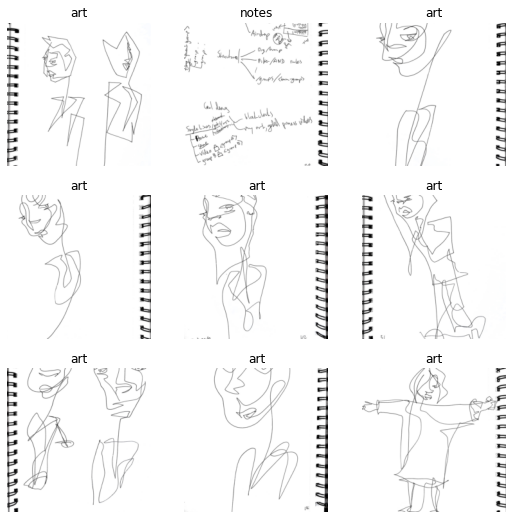

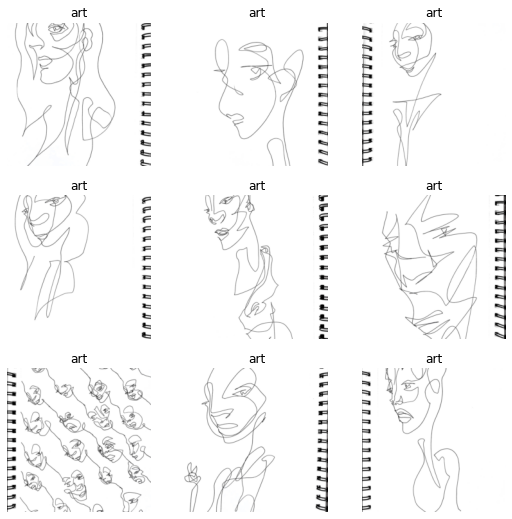

In [ ]:
dls.valid.show_batch(max_n=9, ncols=3)

## Creating batches from sketchbook directory

In [ ]:
#| export
class SketchbookEpoch():
    def __init__(self, epoch, data_home="../data_home"):
        self.data_home = singleline_data_home(default=data_home)
        self.epoch = epoch
        self.raster_epoch = self.data_home / f"raster/epoch-{epoch}"
        self.stroke3_epoch = self.data_home / f"stroke3/epoch-{epoch}"

    def dir_01_FLAT(self):
        return self.raster_epoch / "01_FLAT"

    def dir_02_CATEGORIZED(self):
        return self.raster_epoch / "02_CATEGORIZED"

    def dir_03_HANDLABELED(self):
        return self.raster_epoch / "03_HANDLABELED"

    def dir_04_CROP(self):
        return self.raster_epoch / "04_CROP"
    
    def dir_05_STROKE3(self):
        return self.raster_epoch / "05_STROKE3"
    
    def dir_06_BBOXSEP(self):
        return self.raster_epoch / "06_BBOXSEP"

    def dir_07_FILTER(self):
        return self.raster_epoch / "07_FILTER"

    def dir_08_THRESHOLDED(self):
        return self.raster_epoch / "08_THRESHOLDED"
    
    def tsv_01_FLAT(self):
        return self.raster_epoch / "01_FLAT.tsv"

    def tsv_02_CATEGORIZED(self):
        return self.raster_epoch / "02_CATEGORIZED.tsv"

    def tsv_03_HANDLABELED(self):
        return self.raster_epoch / "03_HANDLABELED.tsv"
    
    def tsv_04_CROP(self):
        return self.raster_epoch / "04_CROP.tsv"

    def tsv_05_STROKE3(self):
        return self.raster_epoch / "05_STROKE3.tsv"
    
    def tsv_06_BBOXSEP(self):
        return self.raster_epoch / "06_BBOXSEP.tsv"

    def tsv_07_FILTER(self):
        return self.raster_epoch / "07_FILTER.tsv"

    def tsv_08_THRESHOLDED(self):
        return self.raster_epoch / "08_THRESHOLDED.tsv"

In [ ]:
EPOCH = SketchbookEpoch(epoch='20231215', data_home='../data_home')
# EPOCH = SketchbookEpoch(epoch='20231214', data_home='../data_home')

sample_path = EPOCH.dir_01_FLAT()
sample_path

no env var SINGLELINE_DATA_HOME, defaulting to: None


Path('../data_home/raster/epoch-20231215/01_FLAT')

In [ ]:
len(get_image_files(EPOCH.dir_01_FLAT()))

366

In [ ]:
len(get_image_files(PREV_EPOCH.dir_01_FLAT()))

246

In [ ]:
#| export
DEFAULT_BATCH_SIZE = 64

def sketchbook_dataloaders(sketchbooks_dir, **kwargs):
    """ Loads image data and label based on parent folder - minimum data needed to train CNN """
    path = Path(sketchbooks_dir)

    files = get_image_files(path)

    path_func = lambda p: os.path.basename(os.path.dirname(p))

    dataloaders = ImageDataLoaders.from_path_func(
        path,
        files,
        path_func,
        item_tfms=Resize(224),
        batch_size=DEFAULT_BATCH_SIZE,
        **kwargs
    )
    return dataloaders


In [ ]:
# #| hide

# """ code to train original model """

# # dataloaders = sketchbook_dataloaders(sample_path / "01_FLAT")
# # print(dataloaders.vocab)
# # learn = vision_learner(dataloaders, resnet34, metrics=error_rate)
# # learn = sketchbook_resnet34(SAMPLE_SKETCHBOOKS_DIR)
# # learn.fine_tune(6)
# # learn.recorder.plot_loss()
# # learn.save("SAMPLE_CHECKPOINT")

../data_home/raster/epoch-20231215/01_FLAT/art/sb44p052.jpg


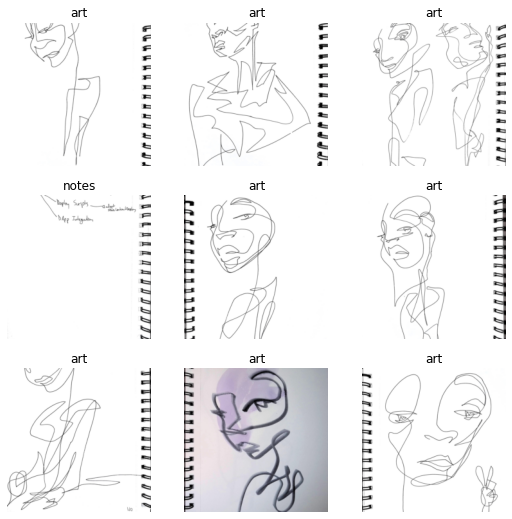

In [ ]:
dls = sketchbook_dataloaders(sample_path)
test_eq(["art", "cover", "notes"], dls.vocab)
print(dls.items[0])
dls.train.show_batch(max_n=9, ncols=3)

In [ ]:
#| export
def batch_fnames_and_images(sketchbooks_dir):
    """
    Prepare data to compute embeddings over all images and store
    them along with a reference to the underlying filename.
    """
    ordered_dls = sketchbook_dataloaders(
        sketchbooks_dir, seed=42, shuffle=False, valid_pct=0.0
    )

    # compute the number of batches
    num_batches = math.ceil(len(ordered_dls.train.items) / DEFAULT_BATCH_SIZE)
    assert num_batches == len(ordered_dls.train)
    batched_fnames = [
        # ensure filenames are relative to the input dir
        [str(s).replace(f"{str(sketchbooks_dir)}/", "") for s in ordered_dls.train.items[i * 64 : (i + 1) * 64]]
        for i in range(num_batches)
    ]
    print(
        f"total items: {len(ordered_dls.train.items)}, num batches: {len(batched_fnames)}"
    )
    return batched_fnames, ordered_dls

In [ ]:
batched_fnames, ordered_dls = batch_fnames_and_images(sample_path)

# ensure all items are in train, none in valid
test_eq(0, len(ordered_dls.valid.items))
test_eq(len(ordered_dls.items), len(ordered_dls.train.items))

# ensure there are the same number of batches
test_eq(len(batched_fnames), len(ordered_dls.train))
test_eq(DEFAULT_BATCH_SIZE, len(batched_fnames[0]))

total items: 366, num batches: 6


In [ ]:
#| hide

## To debug input data, torchvision transform turns tensor back into PIL Image.

# import torchvision.transforms as T
# xform = T.ToPILImage()
# img = xform(x0.squeeze(0))

## Extracting Embeddings

In [ ]:
#| export
def predict_embeddings(model, xb):
    # import pdb
    # pdb.set_trace()
    with torch.no_grad():
        with Hook(model[-1][-2]) as hook:
            output = model.to("cpu").eval()(xb.to("cpu"))
            act = hook.stored
    return act.cpu().numpy()


class Hook:
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)

    def hook_func(self, m, i, o):
        self.stored = o.detach().clone()

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.hook.remove()

In [ ]:
train_iter = iter(ordered_dls.train)
x0, y0 = next(train_iter)
print(x0.shape, y0.shape)

activations = predict_embeddings(learn.model, x0)
activations.shape

torch.Size([64, 3, 224, 224]) torch.Size([64])


(64, 512)

## Bulk-computing embeddings

- [ ] **TODO: remove the 'data_home' literal part of `orig_fname`, so the TSV's can be dir-independent (relative to their data_root)**

In [ ]:
#| export
def embed_dir(input_dir, learner, strip_dir=None):
    """
    Get images paired with their filenames, grouped into batches.
    Compute embeddings and yield JSON records including embedding + filename,
    so the data can be stored for downstream processes that need embeddings
    mapped to specific files (ex. clustering/visual search and taking some
    action like moving files based on the results).

    TODO: remove the 'data_home' literal part of `orig_fname`,
          so the TSV's can be dir-independent (relative to their data_root)
    """
    batched_fnames, ordered_dls = batch_fnames_and_images(input_dir)
    with torch.no_grad(), learner.no_logging():
        for i, batch in enumerate(zip(batched_fnames, ordered_dls.train)):
            batched_fnames, (x, y) = batch
            bs = len(batched_fnames)
            assert bs == x.shape[0]
            assert bs == y.shape[0]

            activations = predict_embeddings(learner.model, x)
            assert bs == activations.shape[0]

            for j in range(bs):
                y_j = y[j]
                fname_j = batched_fnames[j]
                if strip_dir:
                    fname_j = str(fname_j).replace(f"{strip_dir}/", "")
                emb_j = activations[j]
                # label: what parent dir exists in the dataset we're processing
                label_j = ordered_dls.vocab[y_j]
                # # pred_label: prediction made relative to the vocab of the learner's model
                # # (may be different than what's in the dataloader we're using for input).
                # x_j = x[j]
                # pred_label_j, pred_idx_j, pred_probs_j = learner.predict(x_j.cpu())
                yield {
                    "idx": j + i * bs,
                    "indiv_fname": os.path.basename(fname_j),
                    "orig_fname": fname_j,
                    "label": label_j,
                    # "pred_label": pred_label_j,
                    # "pred_idx": pred_idx_j.cpu().numpy(),
                    # "pred_probs": ",".join(
                    #     [f"{p:04f}" for p in pred_probs_j.cpu().numpy()]
                    # ),
                    "emb_csv": ",".join([str(f) for f in list(emb_j)]),
                }

In [ ]:
rows = []
for x in embed_dir(sample_path, learn):
    rows.append(x)
df = pd.DataFrame(rows)

total items: 366, num batches: 6


In [ ]:
df.head()

,idx,indiv_fname,orig_fname,label,emb_csv
0,0,sb46p118.jpg,art/sb46p118.jpg,art,"3.2102692,0.8516708,-0.73929733,-0.6553513,1.4272425,-0.65341413,1.992686,-0.1706771,-0.7537334,-0.42715576,2.5061278,-0.72562873,0.5037714,-0.019189417,-0.38166338,0.19079792,-0.5467274,1.0919871,0.89101017,-0.14793754,-0.64108604,-0.55193967,-0.44920906,-0.6779002,-0.57759243,-0.46846122,-0.4518578,-0.33407718,-0.73986673,-0.45211998,-0.68509877,-0.67007643,1.0507184,-0.4592305,-0.600525,-0.6186755,-0.73933,-0.57338566,0.9525112,1.9176997,-0.27264348,0.9253927,-0.09793198,-0.58915204,-0.75794554,-0.59257406,-0.009822369,0.13793832,-0.651804,0.5137133,-0.59497476,-0.66552746,-0.6482407,0...."
1,1,sb46p043-color.jpg,art/sb46p043-color.jpg,art,"-0.22361127,-0.5714155,-0.73929733,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.3501566,0.8920531,-0.72562873,-0.662768,-0.6266761,-0.68991846,-0.57515705,0.3317588,-0.6520286,-0.6898426,-0.6497359,-0.6159414,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.6690378,-0.20721373,0.8409684,1.1486803,-0.45211998,-0.68509877,-0.67007643,0.62741864,-0.4592305,-0.600525,-0.3025035,-0.73933,-0.57338566,0.12138498,-0.6179389,-0.10531837,0.3007546,0.86806214,0.936227,1.0935233,-0.16803917,-0.6157326,-0.6001429,1.3880448,-0.4944176,-0.2557222,2.7780876,0.2565168,-0.4732165,-0..."
2,2,sb45p113.jpg,art/sb45p113.jpg,art,"0.90266573,-0.5714155,-0.73929733,-0.40889853,0.14828461,0.25614423,0.88512415,-0.4896673,-0.7537334,-0.42715576,1.2945706,-0.72562873,-0.662768,0.1263457,0.6283826,0.20065796,-0.5467274,1.2669592,0.36424387,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.6690378,-0.4518578,0.44213474,1.52933,-0.45211998,-0.68509877,-0.67007643,1.064037,-0.4592305,-0.600525,-0.6186755,-0.73933,-0.57338566,1.5184182,0.43712413,0.48921245,-0.58021957,0.43526626,-0.6682474,-0.75794554,-0.59257406,0.0100159645,-0.6001429,-0.651804,-0.5315948,0.6271075,-0.045659363,-0.05767113,-0.4732165..."
3,3,sb44p046.jpg,art/sb44p046.jpg,art,"3.5505672,0.28784788,-0.73929733,-0.6553513,0.9044825,-0.65341413,0.48211032,0.21118093,-0.7537334,0.018814236,0.8583183,-0.72562873,0.6451347,-0.6266761,-0.68991846,1.909916,-0.5467274,-0.38985994,-0.6898426,-0.6497359,-0.64108604,-0.55193967,0.14504552,-0.6779002,-0.57759243,0.51193213,-0.4518578,-0.5982413,0.3881812,-0.45211998,-0.53891075,-0.67007643,2.2690237,-0.4592305,-0.600525,-0.6186755,-0.55485725,0.10911232,0.22562313,3.2308483,-0.61049384,1.1276355,0.39643216,-0.21786004,-0.75794554,-0.59257406,1.2554562,0.46197563,-0.651804,-0.5315948,-0.59497476,-0.66552746,-0.6482407,-0.2922..."
4,4,sb45p098.jpg,art/sb45p098.jpg,art,"-0.38387868,-0.5714155,-0.1207068,-0.6553513,-0.24014366,0.89072585,2.1695857,-0.1811825,-0.7537334,-0.42715576,0.53433335,-0.72562873,2.1418204,-0.6266761,-0.68991846,-0.32396662,-0.5467274,-0.09009355,-0.44466385,0.322415,-0.64108604,-0.55193967,-0.21749002,1.0327339,-0.57759243,0.64018464,-0.4518578,-0.07862663,-0.73986673,-0.24471335,-0.68509877,-0.67007643,1.7700229,-0.4592305,-0.600525,-0.6186755,-0.73933,-0.57338566,1.7038666,2.3241434,0.7410261,0.20749152,0.78976417,0.6098766,-0.75794554,-0.59257406,-0.6157326,-0.6001429,-0.651804,0.7917171,-0.59497476,-0.66552746,1.7730511,-0.4732..."


## De/Serialize Embeddings

In [ ]:
embeddings_fname = EPOCH.tsv_01_FLAT()
# embeddings_fname = f"{str(sample_path)}.tsv"
df.to_csv(embeddings_fname, index=False, sep="\t", header=True)
print(f"wrote {embeddings_fname}")

wrote ../data_home/raster/epoch-20231215/01_FLAT.tsv


In [ ]:
df = pd.read_csv(embeddings_fname, delimiter="\t")
df.head()

,idx,indiv_fname,orig_fname,label,emb_csv
0,0,sb46p118.jpg,art/sb46p118.jpg,art,"3.2102692,0.8516708,-0.73929733,-0.6553513,1.4272425,-0.65341413,1.992686,-0.1706771,-0.7537334,-0.42715576,2.5061278,-0.72562873,0.5037714,-0.019189417,-0.38166338,0.19079792,-0.5467274,1.0919871,0.89101017,-0.14793754,-0.64108604,-0.55193967,-0.44920906,-0.6779002,-0.57759243,-0.46846122,-0.4518578,-0.33407718,-0.73986673,-0.45211998,-0.68509877,-0.67007643,1.0507184,-0.4592305,-0.600525,-0.6186755,-0.73933,-0.57338566,0.9525112,1.9176997,-0.27264348,0.9253927,-0.09793198,-0.58915204,-0.75794554,-0.59257406,-0.009822369,0.13793832,-0.651804,0.5137133,-0.59497476,-0.66552746,-0.6482407,0...."
1,1,sb46p043-color.jpg,art/sb46p043-color.jpg,art,"-0.22361127,-0.5714155,-0.73929733,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.3501566,0.8920531,-0.72562873,-0.662768,-0.6266761,-0.68991846,-0.57515705,0.3317588,-0.6520286,-0.6898426,-0.6497359,-0.6159414,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.6690378,-0.20721373,0.8409684,1.1486803,-0.45211998,-0.68509877,-0.67007643,0.62741864,-0.4592305,-0.600525,-0.3025035,-0.73933,-0.57338566,0.12138498,-0.6179389,-0.10531837,0.3007546,0.86806214,0.936227,1.0935233,-0.16803917,-0.6157326,-0.6001429,1.3880448,-0.4944176,-0.2557222,2.7780876,0.2565168,-0.4732165,-0..."
2,2,sb45p113.jpg,art/sb45p113.jpg,art,"0.90266573,-0.5714155,-0.73929733,-0.40889853,0.14828461,0.25614423,0.88512415,-0.4896673,-0.7537334,-0.42715576,1.2945706,-0.72562873,-0.662768,0.1263457,0.6283826,0.20065796,-0.5467274,1.2669592,0.36424387,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.6690378,-0.4518578,0.44213474,1.52933,-0.45211998,-0.68509877,-0.67007643,1.064037,-0.4592305,-0.600525,-0.6186755,-0.73933,-0.57338566,1.5184182,0.43712413,0.48921245,-0.58021957,0.43526626,-0.6682474,-0.75794554,-0.59257406,0.0100159645,-0.6001429,-0.651804,-0.5315948,0.6271075,-0.045659363,-0.05767113,-0.4732165..."
3,3,sb44p046.jpg,art/sb44p046.jpg,art,"3.5505672,0.28784788,-0.73929733,-0.6553513,0.9044825,-0.65341413,0.48211032,0.21118093,-0.7537334,0.018814236,0.8583183,-0.72562873,0.6451347,-0.6266761,-0.68991846,1.909916,-0.5467274,-0.38985994,-0.6898426,-0.6497359,-0.64108604,-0.55193967,0.14504552,-0.6779002,-0.57759243,0.51193213,-0.4518578,-0.5982413,0.3881812,-0.45211998,-0.53891075,-0.67007643,2.2690237,-0.4592305,-0.600525,-0.6186755,-0.55485725,0.10911232,0.22562313,3.2308483,-0.61049384,1.1276355,0.39643216,-0.21786004,-0.75794554,-0.59257406,1.2554562,0.46197563,-0.651804,-0.5315948,-0.59497476,-0.66552746,-0.6482407,-0.2922..."
4,4,sb45p098.jpg,art/sb45p098.jpg,art,"-0.38387868,-0.5714155,-0.1207068,-0.6553513,-0.24014366,0.89072585,2.1695857,-0.1811825,-0.7537334,-0.42715576,0.53433335,-0.72562873,2.1418204,-0.6266761,-0.68991846,-0.32396662,-0.5467274,-0.09009355,-0.44466385,0.322415,-0.64108604,-0.55193967,-0.21749002,1.0327339,-0.57759243,0.64018464,-0.4518578,-0.07862663,-0.73986673,-0.24471335,-0.68509877,-0.67007643,1.7700229,-0.4592305,-0.600525,-0.6186755,-0.73933,-0.57338566,1.7038666,2.3241434,0.7410261,0.20749152,0.78976417,0.6098766,-0.75794554,-0.59257406,-0.6157326,-0.6001429,-0.651804,0.7917171,-0.59497476,-0.66552746,1.7730511,-0.4732..."


In [ ]:
#| export
import numpy as np


def pd_series_to_embs(df_emb_csv: pd.Series):
    arrs = [np.array([float(f) for f in s.split(",")]) for s in list(df_emb_csv)]
    embs = np.stack(arrs)
    embs = embs.astype(np.float32)
    return embs

In [ ]:
embs = pd_series_to_embs(df.emb_csv)
print(embs.shape)

(366, 512)


## Clustering

In [ ]:
#| export
import faiss
import json


def train_kmeans(embs, ncentroids=16, **kwargs):
    emb_dim = embs.shape[1]
    index = faiss.IndexFlatL2(emb_dim)
    index.add(embs)
    
    kmeans = faiss.Kmeans(emb_dim, ncentroids, **kwargs)
    kmeans.train(embs)

    return kmeans



In [ ]:
kmeans = train_kmeans(embs, ncentroids=16, seed=42)


Clustering 366 points in 512D to 16 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s


WARNING clustering 366 points to 16 centroids: please provide at least 624 training points


In [ ]:
# # | hide
# ### reproduce original centroids
# # use the full dataset for this, not the tiny sample dataset
# EXTERNAL_EPOCH = singleline_data_home(default='/Users/al/Dropbox/2-Areas/2-Sketchbooks/singleline_data') / f"raster/epoch-{PREV_EPOCH}"
# ext_df = pd.read_csv(EXTERNAL_EPOCH / "01_FLAT/embeddings.tsv", delimiter="\t", index_col="idx")
# ext_df.head()

### sidebar: labeling clusters

This was a manual step, grouping the clusters into labels meaningful to me as a classifier.

Later I could use these clusters (and hand-verify them) to bootstrap a training set for my task of separating watercolors vs. drawings, but for now this works fine.

In [ ]:
# hand-labeled by inspecting clusters
DRAWING_CLUSTERS = [0, 2, 3, 4, 8, 13, 14, 15]
WATERCOLOR_CLUSTERS = [5, 7, 11]
NOTES_CLUSTERS = [9, 12]
BAD_SCANS = [1, 6, 10]
COVERS = []

cluster_to_label = {}

for c in DRAWING_CLUSTERS:
    cluster_to_label[c] = '0_drawings'
for c in WATERCOLOR_CLUSTERS:
    cluster_to_label[c] = '1_watercolors'
for c in NOTES_CLUSTERS:
    cluster_to_label[c] = '2_notes'
for c in BAD_SCANS:
    cluster_to_label[c] = '3_badscans'
for c in COVERS:
    cluster_to_label[c] = '4_covers'

from pprint import pprint
pprint(cluster_to_label)

{0: '0_drawings',
 1: '3_badscans',
 2: '0_drawings',
 3: '0_drawings',
 4: '0_drawings',
 5: '1_watercolors',
 6: '3_badscans',
 7: '1_watercolors',
 8: '0_drawings',
 9: '2_notes',
 10: '3_badscans',
 11: '1_watercolors',
 12: '2_notes',
 13: '0_drawings',
 14: '0_drawings',
 15: '0_drawings'}


## saving / loading clusters

In [ ]:
#| export
def save_centroids(centroids, cluster_to_label, data_home=DEFAULT_DATA_HOME, model_path=PRETRAINED_MODEL_PATH, extra_suffix=""):
    """ 
    Important: centroids labeled for classification are specific to the trained model
    (and its embedding space) rather than to a specific set of images. If I add more
    images over time, I want to map them in the same embedding space to clusters that
    I've already labeled.
    """
    CLUSTER_CENTROIDS_FNAME = data_home / f"{model_path}_cluster_centroids{extra_suffix}.json"
    CLUSTER_LABELS_FNAME = data_home / f"{model_path}_cluster_labels{extra_suffix}.json"

    with open(CLUSTER_CENTROIDS_FNAME, 'w') as outfile:
        json.dump({'centroids': centroids.tolist()}, outfile, indent=2)
    print(f"wrote to {CLUSTER_CENTROIDS_FNAME}")
    with open(CLUSTER_LABELS_FNAME, 'w') as outfile:
        json.dump(cluster_to_label, outfile, indent=2)
    print(f"wrote to {CLUSTER_LABELS_FNAME}")


def load_centroids(data_home=DEFAULT_DATA_HOME, model_path=PRETRAINED_MODEL_PATH, extra_suffix=""):
    CLUSTER_CENTROIDS_FNAME = data_home / f"{model_path}_cluster_centroids{extra_suffix}.json"
    CLUSTER_LABELS_FNAME = data_home / f"{model_path}_cluster_labels{extra_suffix}.json"

    print(f"reading {CLUSTER_CENTROIDS_FNAME}")
    with open(CLUSTER_CENTROIDS_FNAME, 'r') as outfile:
        centroids = np.array(json.load(outfile)['centroids'], dtype=np.float32)
    print(f"reading {CLUSTER_LABELS_FNAME}")
    with open(CLUSTER_LABELS_FNAME, 'r') as outfile:
        cluster_to_label = json.load(outfile)
    return centroids, cluster_to_label

In [ ]:
## important: don't overwrite clusters computed from full dataset w/ ones computed from tiny sample set
# save_centroids(kmeans.centroids, cluster_to_label)

## Using Cluster KNN Classifier

In [ ]:
#| export
def cluster_assigner(cluster_centroids, cluster_to_label=None):
    emb_dim = cluster_centroids.shape[1]
    kmeans_index = faiss.IndexFlatL2(emb_dim)
    kmeans_index.add(cluster_centroids)

    def __knn_assigner(embs):
        knn_dist, knn_clusterid = kmeans_index.search(embs, 1)
        knn_label = [cluster_to_label[str(i[0])] for i in knn_clusterid] if cluster_to_label else [None]*len(knn_clusterid)
        return knn_dist, knn_clusterid, knn_label
    return __knn_assigner

In [ ]:
centroids, cluster_to_label = load_centroids(
    data_home=singleline_data_home('../data_home'),
    model_path=PRETRAINED_MODEL_PATH
)
assigner = cluster_assigner(centroids, cluster_to_label)

no env var SINGLELINE_DATA_HOME, defaulting to: None
reading ../data_home/models/epoch-20231128/01_FLAT_cluster_centroids.json
reading ../data_home/models/epoch-20231128/01_FLAT_cluster_labels.json


In [ ]:
# assign nearest centroid to each
embs = pd_series_to_embs(df.emb_csv)
knn_dist, knn_clusterid, knn_label = assigner(embs)
knn_label[:5], knn_clusterid[:5]

(['0_drawings', '1_watercolors', '0_drawings', '0_drawings', '0_drawings'],
 array([[2],
        [7],
        [3],
        [2],
        [4]]))

In [ ]:
len(df)

366

In [ ]:
categorized_fname = EPOCH.tsv_02_CATEGORIZED()
categorized_dir = EPOCH.dir_02_CATEGORIZED()

df["knn_dist"] = knn_dist
df["knn_clusterid"] = knn_clusterid
df["knn_label"] = knn_label

df["categorized_path"] = df.apply(
    lambda row: os.path.join(row["knn_label"], row["indiv_fname"]), axis=1
)

if 'emb_csv' in df.columns:
    del df['emb_csv']

df.head()

,idx,indiv_fname,orig_fname,label,knn_dist,knn_clusterid,knn_label,categorized_path
0,0,sb46p118.jpg,art/sb46p118.jpg,art,109.942535,2,0_drawings,0_drawings/sb46p118.jpg
1,1,sb46p043-color.jpg,art/sb46p043-color.jpg,art,222.025574,7,1_watercolors,1_watercolors/sb46p043-color.jpg
2,2,sb45p113.jpg,art/sb45p113.jpg,art,164.678162,3,0_drawings,0_drawings/sb45p113.jpg
3,3,sb44p046.jpg,art/sb44p046.jpg,art,205.636505,2,0_drawings,0_drawings/sb44p046.jpg
4,4,sb45p098.jpg,art/sb45p098.jpg,art,183.912903,4,0_drawings,0_drawings/sb45p098.jpg


<Axes: >

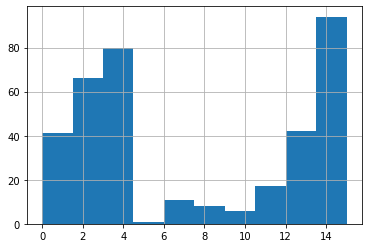

In [ ]:
# NOTE: when saving embeddings CSV, idx was a regular column (not a pandas 'index').
# When reloaded, 'idx' was made the index column. TODO: make original DF use 'idx' as index,
# so saving and reloading code is identical.
df.to_csv(categorized_fname, index=True, index_label="idx", sep="\t", header=True)

cdf = pd.read_csv(categorized_fname, delimiter="\t", index_col="idx")
cdf.knn_clusterid.hist()

<Axes: >

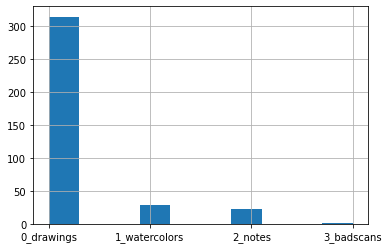

In [ ]:
cdf.knn_label.hist()

## Visualizing Clusters

In [ ]:
#| export
def show_cluster(clusters_df, clusters, idx, colname='orig_fname', prefix=None):
    imgs = [Image.open(prefix / clusters_df.iloc[i][colname]) for i in clusters[idx]]

    fig = plt.figure(figsize=(16.0, 16.0))
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=(4, 4),  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    plt.show()

In [ ]:
#| export
def show_all_clusters(clusters_df, clusters, cluster_idxs=None, title=None, colname='orig_fname', prefix = None):
    select_idxs = cluster_idxs if cluster_idxs else range(len(clusters))
    num_clusters = len(select_idxs)
    examples_per_cluster = 16
    fig = plt.figure(figsize=(16.0, float(num_clusters)))
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=(num_clusters, examples_per_cluster),
        axes_pad=0.02,
    )
    for row, cluster_idx in enumerate(select_idxs):
        imgs = [
            Image.open(prefix / clusters_df.iloc[i][colname]) for i in clusters[cluster_idx]
        ]

        for col, im in enumerate(imgs):
            total_idx = col + row * examples_per_cluster
            ax = grid[total_idx]
            ax.grid = False
            ax.set_xticks([])
            ax.set_yticks([])
            if col == 0:
                ax.set_ylabel(f"{cluster_idx}  ", rotation=0)
            ax.imshow(im)
    if title:
        fig.suptitle(
            title
            if cluster_idxs is None
            else f"{title} (Cluster IDs: {','.join([str(i) for i in select_idxs])})"
        )
    plt.show()

In [ ]:
# show_cluster(clusters_df=cdf, clusters=knn_clusterid, idx=14, colname='orig_fname', prefix=EPOCH.dir_01_FLAT())

In [ ]:
# show_all_clusters(clusters_df=cdf, clusters=knn_clusterid, prefix=EPOCH.dir_01_FLAT())

## Moving files

In [ ]:
# test_files = get_image_files(EPOCH.dir_01_FLAT())
# indiv_fnames = L(os.path.basename(f) for f in test_files)
# indiv_fnames

In [ ]:
# cdf.head()

In [ ]:
#| export
import math
import os
import shutil

from PIL import Image

def categorize_files(cdf, epoch, prev_epoch=None):
    existing_categorized = L(os.path.basename(f) for f in get_image_files(epoch.dir_02_CATEGORIZED()))
    prev_handlabeled = L(os.path.basename(f) for f in get_image_files(prev_epoch.dir_03_HANDLABELED())) if prev_epoch else []

    for idx in range(len(cdf)):
        row = cdf.iloc[idx]
    
        indiv_fname = row.indiv_fname
        if prev_handlabeled and indiv_fname in prev_handlabeled:
            print(f"already hand-labeled in 03_HANDLABELED (PREV epoch) - skipping {indiv_fname} (to avoid duplicate work)")
            continue
        
        if indiv_fname in existing_categorized:
            print(f"already copied to 02_CATEGORIZED (curr epoch) - skipping {indiv_fname}")
            continue
    
        orig_abs_path = epoch.dir_01_FLAT() / row.orig_fname
        categorized_abs_path = epoch.dir_02_CATEGORIZED() / row.categorized_path
    
        categorized_dir = os.path.dirname(categorized_abs_path)
        if not os.path.isdir(categorized_dir):
            os.makedirs(categorized_dir)
    
        print(f"writing to {categorized_abs_path}")
        shutil.copy(orig_abs_path, categorized_abs_path)

In [ ]:
# categorize_files(cdf, epoch=EPOCH, prev_epoch=None)

TODO:
- [x] sample data:
    - [x] rename 03_HANDLABELED
- [ ] external data home:
    - [x] rename 03_HANDLABELED
    - [x] ensure centroids / trained models in same path
    - [ ] re-generate TSV files

Notebooks for E2E run:
- First time, training vision model + determining what clusters mean
- Second time, reapplying trained model / centroids

In [ ]:
PREV_EPOCH = SketchbookEpoch(epoch='20231214', data_home='../data_home')
# EPOCH = SketchbookEpoch(epoch='20231215', data_home='../data_home')

PREV_01_FLAT = PREV_EPOCH.dir_01_FLAT()
PREV_02_CATEGORIZED = PREV_EPOCH.dir_02_CATEGORIZED()
PREV_03_HAND = PREV_EPOCH.dir_03_HANDLABELED()

# CURR_01_FLAT = PREV_EPOCH.dir_01_FLAT()
# CURR_02_CATEGORIZED = PREV_EPOCH.dir_02_CATEGORIZED()
# CURR_03_HAND = PREV_EPOCH.dir_03_HANDLABELED()

categorize_files(cdf, epoch=EPOCH, prev_epoch=PREV_EPOCH)

no env var SINGLELINE_DATA_HOME, defaulting to: None
writing to ../data_home/raster/epoch-20231215/02_CATEGORIZED/0_drawings/sb46p118.jpg
writing to ../data_home/raster/epoch-20231215/02_CATEGORIZED/1_watercolors/sb46p043-color.jpg
already hand-labeled in 03_HANDLABELED (PREV epoch) - skipping sb45p113.jpg (to avoid duplicate work)
already hand-labeled in 03_HANDLABELED (PREV epoch) - skipping sb44p046.jpg (to avoid duplicate work)
already hand-labeled in 03_HANDLABELED (PREV epoch) - skipping sb45p098.jpg (to avoid duplicate work)
already hand-labeled in 03_HANDLABELED (PREV epoch) - skipping sb44p011.jpg (to avoid duplicate work)
writing to ../data_home/raster/epoch-20231215/02_CATEGORIZED/2_notes/sb46p060-selling-tokens.jpg
already hand-labeled in 03_HANDLABELED (PREV epoch) - skipping sb44p032.jpg (to avoid duplicate work)
already hand-labeled in 03_HANDLABELED (PREV epoch) - skipping sb44p026.jpg (to avoid duplicate work)
already hand-labeled in 03_HANDLABELED (PREV epoch) - skipp

In [ ]:
# epoch = EPOCH
# prev_epoch = PREV_EPOCH

# prev_handlabeled = L(os.path.basename(f) for f in get_image_files(prev_epoch.dir_03_HANDLABELED())) if prev_epoch else []

In [ ]:
# prev_handlabeled

(#245) ['sb45pcover-v0.jpg','sb45pcover-v1-light.jpg','sb44p049.jpg','sb44p061.jpg','sb44p075.jpg','sb45p058.jpg','sb45p070.jpg','sb45p064.jpg','sb45p104.jpg','sb45p110.jpg'...]

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()